<a href="https://colab.research.google.com/github/CharlottePrimiceri/VP_Project/blob/main/MaskR_CNN_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Segmented video generation applying the pre-trained Mask-RCNN and our trained U-Net.**

References:

- Mask-RCNN:
https://github.com/facebookresearch/detectron2.git@5aeb252b194b93dc2879b4ac34bc51a31b5aee13'
- Video taken from: https://www.cityscapes-dataset.com/

# Libraries

In [ ]:
!pip install torchvision --quiet

In [ ]:
! pip install scikit-image --quiet

In [ ]:
! pip install opencv-python --quiet

In [ ]:
! pip install Pillow --quiet

In [ ]:
import os
import PIL
from PIL import Image
import cv2
import matplotlib.pyplot as plt

import numpy as np
import torch
import json
import scipy
import skimage
import pandas

from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from google.colab.patches import cv2_imshow

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"

# Cityscapes Conversion to COCO Format

In [ ]:
! git clone https://github.com/ISSResearch/Dataset-Converters

In [ ]:
! pip install -r /content/Dataset-Converters/requirements.txt

In [ ]:
! python /content/Dataset-Converters/convert.py -i /content/drive/MyDrive/VPPROJECT/cityscapes -o /content/drive/MyDrive/VPPROJECT/cityscapes/annotations -I CITYSCAPES -O COCO --copy

# Filtering 3 Classes: Person, Car and Bicycle

In [ ]:
filtered_annotations_file = "filtered_annotations.json"

# Specify the IDs of the desired classes to keep
classes = [1, 2, 3]

# Load the COCO annotations
with open("/content/drive/MyDrive/VPPROJECT/cityscapes/annotations/train.json", "r") as f:
    data = json.load(f)

# Filter the annotations for the desired classes
filtered_annotations = {
    "images": data["images"],
    "categories": [category for category in data["categories"] if category["id"] in classes],
    "annotations": [annotation for annotation in data["annotations"] if annotation["category_id"] in classes]
}

# Save the filtered annotations to a new JSON file
with open(filtered_annotations_file, "w") as f:
    json.dump(filtered_annotations, f)

In [ ]:
filtered_annotations_file = "filtered_annotations_val.json"

# Load the COCO annotations
with open("/content/drive/MyDrive/VPPROJECT/cityscapes/annotations/val.json", "r") as f:
    data = json.load(f)

filtered_annotations = {
    "images": data["images"],
    "categories": [category for category in data["categories"] if category["id"] in classes],
    "annotations": [annotation for annotation in data["annotations"] if annotation["category_id"] in classes]
}

with open(filtered_annotations_file, "w") as f:
    json.dump(filtered_annotations, f)

In [ ]:
with open('/content/drive/MyDrive/VPPROJECT/cityscapes/annotations/train.json') as json_data:
    data = json.load(json_data)
    df3_pandas = pd.DataFrame(data['categories'])
df3_pandas
list_of_values = [1, 3, 8]
df3 = df3_pandas[df3_pandas['id'].isin(list_of_values)]
print(df3)
df3_json = df3.to_dict(orient='dict')

# Detectron2 Configuration on Cityscapes

In [ ]:
! git clone https://github.com/facebookresearch/detectron2 --quiet

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git' --quiet

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 751.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.2/182.2 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 10.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [ ]:
import detectron2
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode

In [ ]:
cfg = get_cfg()
cfg.MODEL.DEVICE = "cpu"

# Register Dataset Annotations

In [ ]:
DatasetCatalog.clear()

In [ ]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_traini", {}, "/content/drive/MyDrive/VPPROJECT/cityscapes/annotations/filtered_annotations.json", "/content/drive/MyDrive/VPPROJECT/cityscapes/annotations/train")

In [ ]:
nuts_metadata = MetadataCatalog.get('my_dataset_traini').set(thing_colors=[(255,0,0), (0,255,0), (0,0,255)])
dataset_dicts = DatasetCatalog.get('my_dataset_traini')

## Visualize Original Image and Prediction


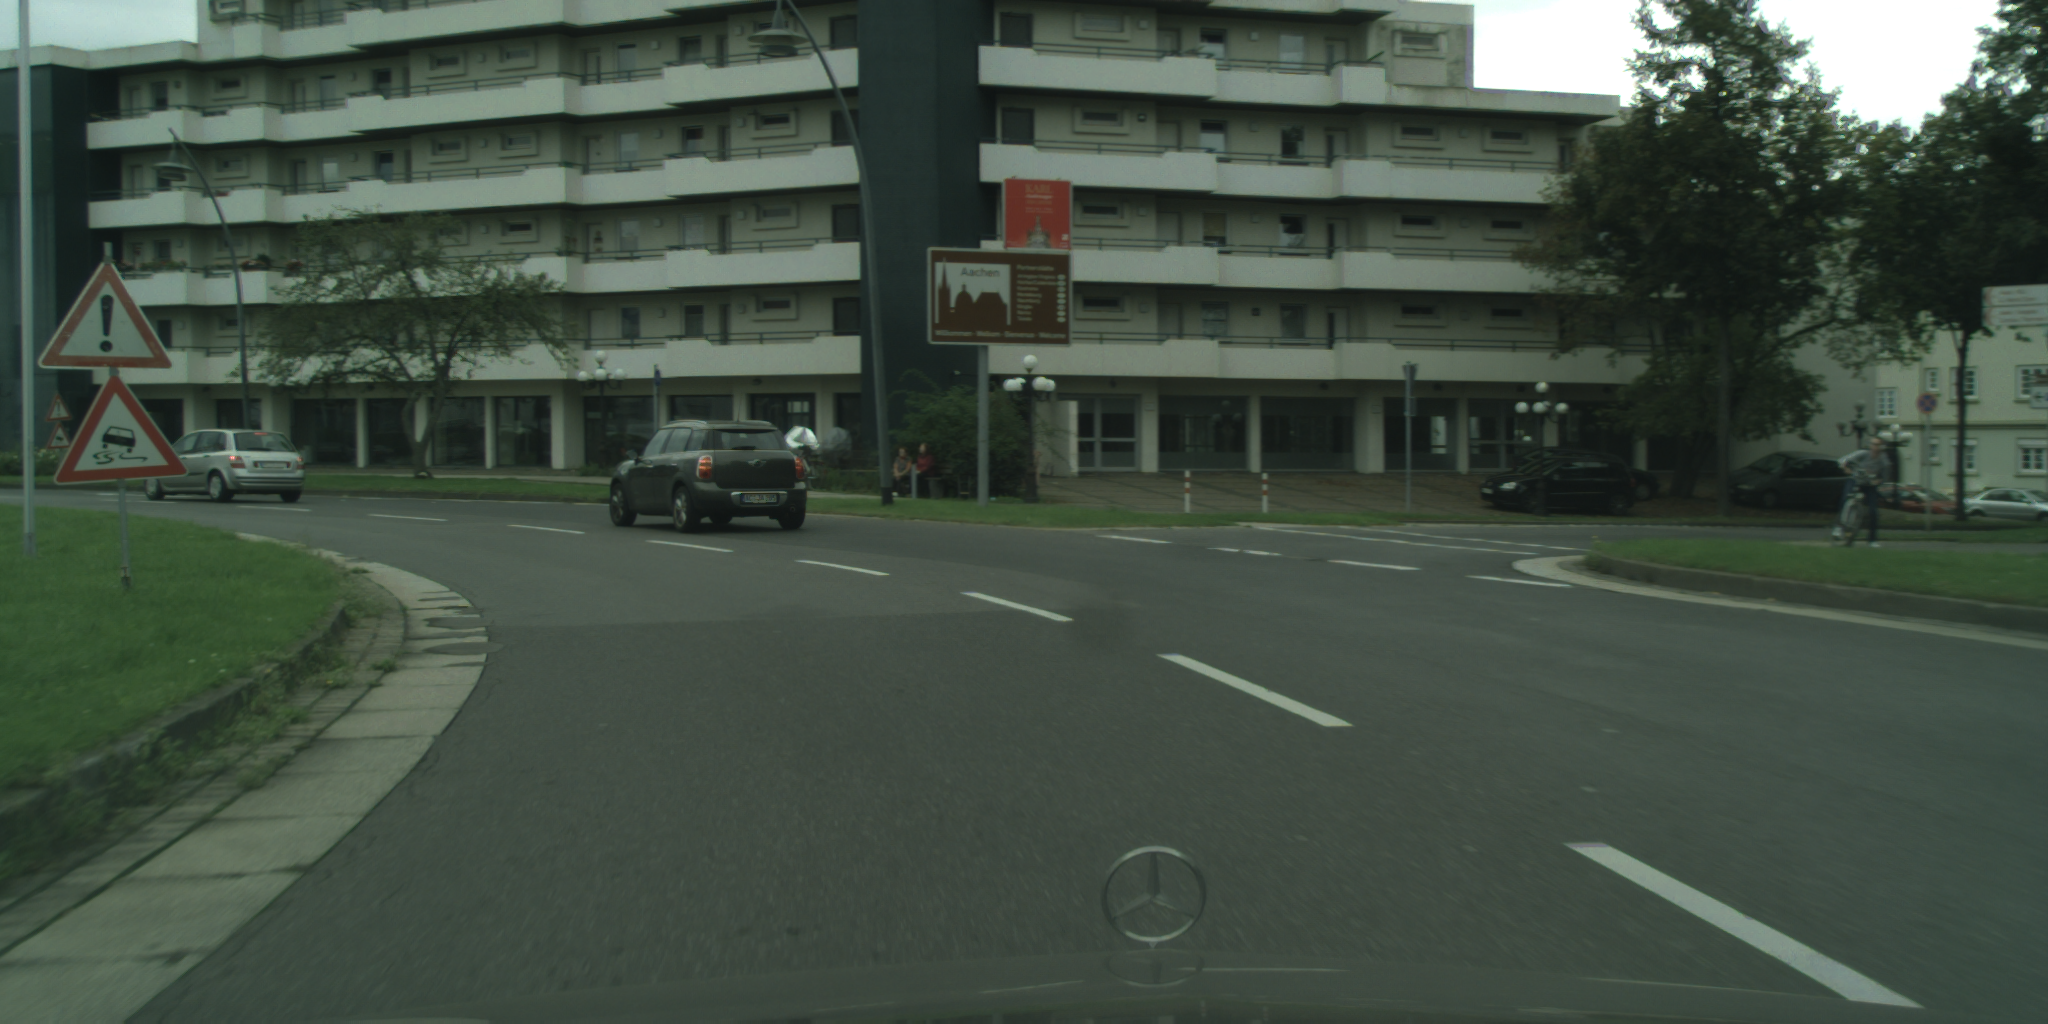

In [ ]:
im = cv2.imread("/content/drive/MyDrive/VPPROJECT/cityscapes/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png")
cv2_imshow(im)

In [ ]:
# ResNet 50 as backbone
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
# Load previous weights
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

model_final_f10217.pkl: 178MB [00:02, 70.4MB/s]                           
/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# prediction values of classes and bounding boxes
print(outputs["instances"].pred_classes)
print(outputs["instances"].pred_boxes)

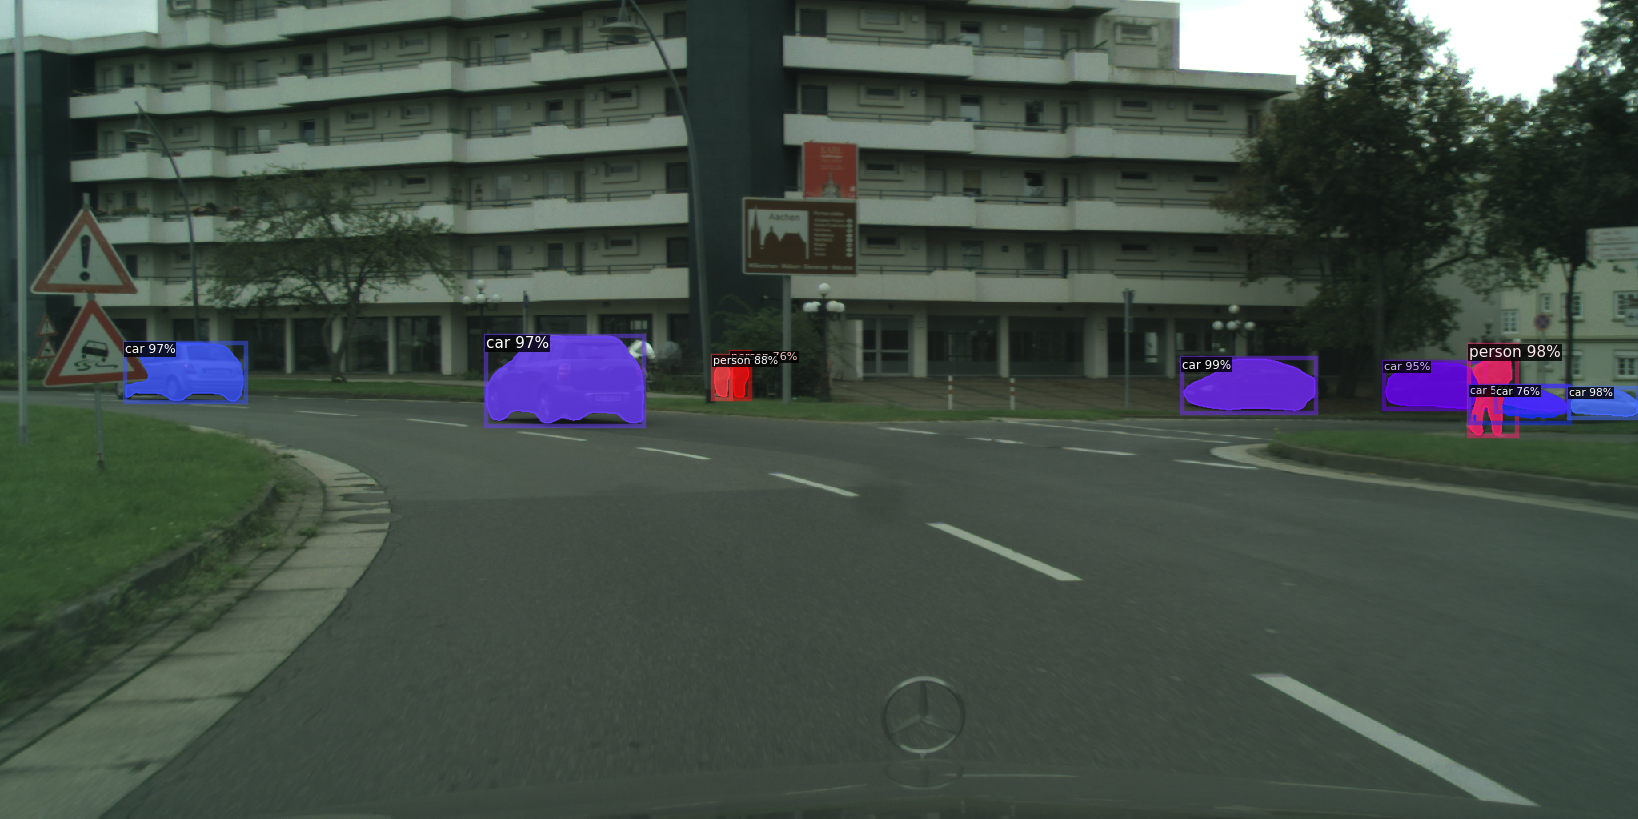

In [ ]:
# Set different shades of colors for different classes
v = Visualizer(im[:, :, ::-1], nuts_metadata, scale=0.8, instance_mode=ColorMode.SEGMENTATION)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

# Convert Video to Image Sequence

In [ ]:
capture = cv2.VideoCapture('/content/drive/MyDrive/VPPROJECT/EUREKA/video_making/demoVideo/')

frameNr = 0

while (True):

    success, frame = capture.read()

    if success:
        cv2.imwrite(f'/content/drive/MyDrive/VPPROJECT/EUREKA/video_making/demoVideo/video_car/out_img2/{frameNr:04d}.jpg', frame)

    else:
        break

    frameNr = frameNr+1

capture.release()

In [ ]:
path_segmented_car = "/content/drive/MyDrive/VPPROJECT/EUREKA/video_making/demoVideo/stuttgart_02_output"

list_frames = [frame for frame in os.listdir(path_segmented_car) if frame.endswith(".png")]

for i, list_frames in enumerate(list_frames, start=1):
    new_filename = f"{i:04d}.png"

    old_path = os.path.join(path_segmented_car, list_frames)
    new_path = os.path.join(path_segmented_car, new_filename)

    os.rename(old_path, new_path)

    print(f"Renamed '{list_frames}' to '{new_filename}'")

# Pass frames to Mask R-CNN to obtain a segmented video

In [ ]:
#video_path = "/content/drive/MyDrive/VPPROJECT/EUREKA/video_making/demoVideo/video_car/out_img2/"       # video frames
#segmented_video_path = "/content/drive/MyDrive/VPPROJECT/EUREKA/video_making/demoVideo/segmented_car2/" # segmented video frames
#built_video_path = "/content/drive/MyDrive/VPPROJECT/EUREKA/video_making/demoVideo/built_video_car/"    # folder for ouput video

video_path = "/content/drive/MyDrive/VPPROJECT/EUREKA/video_making/demoVideo/stuttgart_02_output"       # video frames
segmented_video_path = "/content/drive/MyDrive/VPPROJECT/EUREKA/video_making/demoVideo/segmented_video_pedestrian/" # segmented video frames
built_video_path = "/content/drive/MyDrive/VPPROJECT/EUREKA/video_making/demoVideo/built_video_pedestrian/"


#sort frames in order to create the video from the right sequence of frames
def frame_sort_key(filename):
    return int(filename.split('.')[0])

def generate_video(img_folder, video_name, out_path):

    images = [img for img in os.listdir(img_folder)]
    images.sort(key=frame_sort_key)
    frame = cv2.imread(os.path.join(img_folder, images[0]))
    height, width, layers = frame.shape

    os.chdir(out_path)

    video = cv2.VideoWriter(video_name, 0, 1, (width, height))

    for image in images:
        video.write(cv2.imread(os.path.join(img_folder, image)))

    cv2.destroyAllWindows()
    video.release()



for image in os.listdir(video_path):
    image_path = os.path.join(video_path, image)
    im = cv2.imread(image_path)

    # here we segment the image with the pre-trained Mask-RCNN
    pred = predictor(im)
    instances = pred["instances"]
    target_car_id = 0
    ped_instances = instances[instances.pred_classes == target_car_id]
    v = Visualizer(im[:, :, ::-1], nuts_metadata, scale=0.8, instance_mode=ColorMode.SEGMENTATION)
    out = v.draw_instance_predictions(ped_instances.to("cpu"))
    path = os.path.join(segmented_video_path, image)
    cv2.imwrite(path, out.get_image()[:, :, ::-1])


# Build video
generate_video(segmented_video_path, "segmented_video_pedestrian.avi", built_video_path)

##Pytorch-UNet PREDICT SCRIPT

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import argparse
import numpy as np

import random
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torchvision import transforms, utils
import torchvision.transforms.functional as TF
from collections import namedtuple
import torch.nn as nn
import torchvision
import torch.utils as utils
import torch.nn.init as init
import torch.utils.data as data
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.autograd import Variable
import pdb

In [ ]:
############# MODEL BLOCKS ######################################

def conv_block(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        nn.Conv2d(in_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model


def conv_trans_block(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        nn.ConvTranspose2d(in_dim, out_dim, kernel_size=3, stride=2, padding=1, output_padding=1),
        nn.BatchNorm2d(out_dim),
        act_fn,
    )
    return model


def maxpool():
    pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
    return pool


def conv_block_2(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        conv_block(in_dim, out_dim, act_fn),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model


def conv_block_3(in_dim, out_dim, act_fn):
    model = nn.Sequential(
        conv_block(in_dim, out_dim, act_fn),
        conv_block(out_dim, out_dim, act_fn),
        nn.Conv2d(out_dim, out_dim, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(out_dim),
    )
    return model

################## MODEL #################################


class UnetGenerator(nn.Module):

    def __init__(self, in_dim, out_dim, num_filter):
        super(UnetGenerator, self).__init__()
        self.in_dim = in_dim
        self.out_dim = out_dim
        self.num_filter = num_filter
        act_fn = nn.LeakyReLU(0.2, inplace=True)

        self.down_1 = conv_block_2(self.in_dim, self.num_filter, act_fn)
        self.pool_1 = maxpool()
        self.down_2 = conv_block_2(self.num_filter*1, self.num_filter*2, act_fn)
        self.pool_2 = maxpool()
        self.down_3 = conv_block_2(self.num_filter*2, self.num_filter*4, act_fn)
        self.pool_3 = maxpool()
        self.down_4 = conv_block_2(self.num_filter*4, self.num_filter*8, act_fn)
        self.pool_4 = maxpool()

        self.bridge = conv_block_2(self.num_filter*8, self.num_filter*16, act_fn)

        self.trans_1 = conv_trans_block(self.num_filter*16, self.num_filter*8, act_fn)
        self.up_1 = conv_block_2(self.num_filter*16, self.num_filter*8, act_fn)
        self.trans_2 = conv_trans_block(self.num_filter*8, self.num_filter*4, act_fn)
        self.up_2 = conv_block_2(self.num_filter*8, self.num_filter*4, act_fn)
        self.trans_3 = conv_trans_block(self.num_filter*4, self.num_filter*2, act_fn)
        self.up_3 = conv_block_2(self.num_filter*4, self.num_filter*2, act_fn)
        self.trans_4 = conv_trans_block(self.num_filter*2, self.num_filter*1, act_fn)
        self.up_4 = conv_block_2(self.num_filter*2, self.num_filter*1, act_fn)

        self.out = nn.Sequential(
            nn.Conv2d(self.num_filter, self.out_dim, 3, 1, 1),
            nn.Tanh(),
        )

    def forward(self, input):
        down_1 = self.down_1(input)
        pool_1 = self.pool_1(down_1)
        down_2 = self.down_2(pool_1)
        pool_2 = self.pool_2(down_2)
        down_3 = self.down_3(pool_2)
        pool_3 = self.pool_3(down_3)
        down_4 = self.down_4(pool_3)
        pool_4 = self.pool_4(down_4)

        bridge = self.bridge(pool_4)

        trans_1 = self.trans_1(bridge)
        concat_1 = torch.cat([trans_1, down_4], dim=1)
        up_1 = self.up_1(concat_1)
        trans_2 = self.trans_2(up_1)
        concat_2 = torch.cat([trans_2, down_3], dim=1)
        up_2 = self.up_2(concat_2)
        trans_3 = self.trans_3(up_2)
        concat_3 = torch.cat([trans_3, down_2], dim=1)
        up_3 = self.up_3(concat_3)
        trans_4 = self.trans_4(up_3)
        concat_4 = torch.cat([trans_4, down_1], dim=1)
        up_4 = self.up_4(concat_4)

        out = self.out(up_4)

        return out

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

generator = UnetGenerator(3, 4, 64).to(device)

parser = argparse.ArgumentParser()
parser.add_argument("--num_gpu", type=int, default=0, help="number of gpus")
parser.add_argument("-f", required=False)
args = parser.parse_args()

# load pretrained model if it is there
print("loading unet model...")
file_model = '/content/drive/MyDrive/VPPROJECT/EUREKA/checkpoint_UNet/unet.pkl'
if os.path.isfile(file_model):
    generator = torch.load(file_model, map_location=torch.device('cpu'))
    print("    - model restored from file....")
    print("    - filename = %s" % file_model)
else:
    print("unable to load unet.pkl model file")
    exit()

print("\n(predicting all the segmented frames will take a while)...")

# load images from folder
folder_path = "/content/drive/MyDrive/VPPROJECT/EUREKA/video_making/demoVideo/stuttgart_02_output/"
segmented_images = []
i = 0
for file in os.listdir(folder_path):
      i+=1
      img_path = os.path.join(folder_path, file)
      image = Image.open(img_path).convert('RGB')
      transform_image = torchvision.transforms.Compose([
                                    torchvision.transforms.Resize(size=(128, 256), interpolation=Image.BILINEAR),
                                    torchvision.transforms.ToTensor()])
      image = transform_image(image)
      image = torch.unsqueeze(image, 0)
      x = Variable(image).to(device)
      y = generator.forward(x)
      pred_class = torch.zeros((y.size()[0], y.size()[2], y.size()[3]))
      for idx in range(0, y.size()[0]):
          pred_class[idx] = torch.argmax(y[idx], dim=0).to(device).int()
      pred_class = pred_class.unsqueeze(1).float()
      v_utils.save_image(pred_class.float()/y.size()[1], '/content/drive/MyDrive/VPPROJECT/EUREKA/video_making/demoVideo/predict_segmented_unet/gen_image_{}.png'.format(i))

## Video built with Pytorch-Unet-revisited predictions

In [ ]:
# Build video from folder segmented_video
segmented_video_unet_path = "/content/drive/MyDrive/VPPROJECT/EUREKA/video_making/demoVideo/predict_segmented_unet/"
built_video_unet_path = "/content/drive/MyDrive/VPPROJECT/EUREKA/video_making/demoVideo/built_video_unet/"
generate_video(segmented_video_unet_path, "/content/drive/MyDrive/VPPROJECT/EUREKA/video_making/demoVideo/segmented_video_unet.avi", built_video_unet_path)
print("The segmented video has been generated now!")